<a href="https://colab.research.google.com/github/jannat99/ML/blob/main/Assignment_1_170204051.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchmetrics
import os
import torch
import torchvision
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data.dataloader import DataLoader
import torchmetrics
import math

     |████████████████████████████████| 397 kB 13.4 MB/s 


In [ ]:
data_dir = '/content/drive/My Drive/My 4-2/imagery/'

In [ ]:
train_transform = transforms.Compose([
                  transforms.Grayscale(num_output_channels=1),
                  transforms.Resize((32, 32)), 
                  transforms.ToTensor(),])

In [ ]:
dataset = ImageFolder(data_dir, transform=train_transform)
print(dataset)

Dataset ImageFolder
    Number of datapoints: 4482
    Root location: /content/drive/My Drive/My 4-2/imagery/
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )


In [ ]:
random_seed = 51
torch.manual_seed(random_seed);
test_size = math.floor(0.2 * len(dataset))
val_size = math.floor(0.15 * len(dataset))
train_size = len(dataset) - val_size - test_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
len(train_dataset), len(val_dataset), len(test_dataset)

(2914, 672, 896)

In [ ]:
def accuracy(outputs, labels):
  metric = torchmetrics.Accuracy()
  metric = metric.cuda()
  return metric(outputs, labels)

def precision(outputs, labels):
  metric = torchmetrics.Precision(average='macro', num_classes=4)
  metric = metric.cuda()
  return metric(outputs, labels)

def recall(outputs, labels):
  metric = torchmetrics.Recall(average='macro', num_classes=4)
  metric = metric.cuda()
  return metric(outputs, labels)

def f1_score(outputs, labels):
  pr = precision(outputs, labels)
  re = recall(outputs, labels)
  return 2 * pr * re / (pr + re)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
class NNModel(nn.Module):
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        self.linear1 = nn.Linear(in_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, hidden_size)
        self.linear4 = nn.Linear(hidden_size, hidden_size)
        self.linear5 = nn.Linear(hidden_size, hidden_size)
        self.linear6 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.linear4(out)
        out = F.relu(out)
        out = self.linear5(out)
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear6(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        prec = precision(out, labels)
        rec = recall(out, labels)
        f1 = f1_score(out, labels)
        return {'val_loss':loss, 'val_acc': acc, 'val_recall': rec, 'val_precision': prec, 'val_f1': f1}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()  
        batch_recall = [x['val_recall'] for x in outputs]
        epoch_recall = torch.stack(batch_recall).mean()  
        batch_precision = [x['val_precision'] for x in outputs]
        epoch_precision = torch.stack(batch_precision).mean()  
        batch_f1 = [x['val_f1'] for x in outputs]
        epoch_f1 = torch.stack(batch_f1).mean()     
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item(), 'val_recall': epoch_recall.item(), 'val_precision': epoch_precision.item(), 'val_f1': epoch_f1.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}, val_recall: {:.4f}, val_precision: {:.4f}, val_f1: {:.4f}".format(epoch, result['val_loss'], result['val_acc'], result['val_recall'], result['val_precision'], result['val_f1']))

In [ ]:
input_size = 32*32
hidden_size = 100
num_classes = 4

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
batch_size = 25
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
validation_dataloader = DataLoader(val_dataset, batch_size)
test_dataloader = DataLoader(test_dataset, batch_size)
model = NNModel(input_size, hidden_size, out_size=num_classes)

# Moving the model and datasets to default device (gpu if available)
to_device(model, device)
train_dataloader = DeviceDataLoader(train_dataloader, device)
validation_dataloader = DeviceDataLoader(validation_dataloader, device)
test_dataloader = DeviceDataLoader(test_dataloader, device)

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
# Model (on GPU)
model = NNModel(input_size, hidden_size, out_size=num_classes)
model.to(device)

NNModel(
  (linear1): Linear(in_features=1024, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=100, bias=True)
  (linear4): Linear(in_features=100, out_features=100, bias=True)
  (linear5): Linear(in_features=100, out_features=100, bias=True)
  (linear6): Linear(in_features=100, out_features=4, bias=True)
)

In [ ]:
num_epochs = 200
lr = 0.001

In [ ]:
history = fit(num_epochs, lr, model, train_dataloader, validation_dataloader)

Epoch [0], val_loss: 1.3547, val_acc: 0.6667, val_recall: 0.3113, val_precision: 0.2087, val_f1: 0.2480
Epoch [1], val_loss: 1.3081, val_acc: 0.6667, val_recall: 0.3113, val_precision: 0.2087, val_f1: 0.2480
Epoch [2], val_loss: 1.2657, val_acc: 0.6667, val_recall: 0.3113, val_precision: 0.2087, val_f1: 0.2480
Epoch [3], val_loss: 1.2271, val_acc: 0.6667, val_recall: 0.3113, val_precision: 0.2087, val_f1: 0.2480
Epoch [4], val_loss: 1.1920, val_acc: 0.6667, val_recall: 0.3113, val_precision: 0.2087, val_f1: 0.2480
Epoch [5], val_loss: 1.1603, val_acc: 0.6667, val_recall: 0.3113, val_precision: 0.2087, val_f1: 0.2480
Epoch [6], val_loss: 1.1319, val_acc: 0.6667, val_recall: 0.3113, val_precision: 0.2087, val_f1: 0.2480
Epoch [7], val_loss: 1.1065, val_acc: 0.6667, val_recall: 0.3113, val_precision: 0.2087, val_f1: 0.2480
Epoch [8], val_loss: 1.0839, val_acc: 0.6667, val_recall: 0.3113, val_precision: 0.2087, val_f1: 0.2480
Epoch [9], val_loss: 1.0640, val_acc: 0.6667, val_recall: 0.3113

In [ ]:
import matplotlib.pyplot as plt
def plot_accuracies(history, metric, ylabel, title):
    accuracies = [x[metric] for x in history]
    plt.plot(accuracies)
    plt.xlabel('epoch')
    plt.ylabel(ylabel)
    plt.title(title);

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-b')
    plt.plot(val_losses, '-r')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

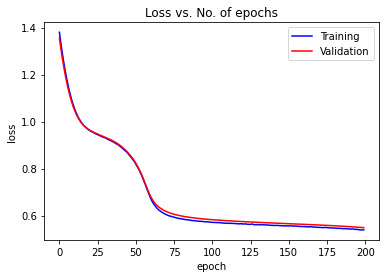

In [ ]:
plot_losses(history)

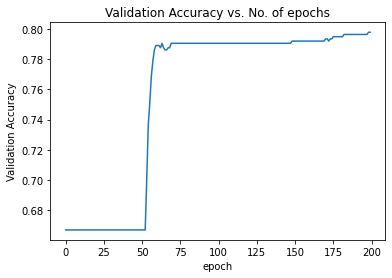

In [ ]:
plot_accuracies(history, 'val_acc', 'Validation Accuracy', 'Validation Accuracy vs. No. of epochs')

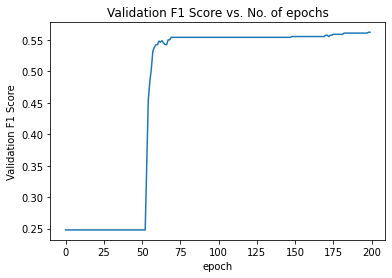

In [ ]:
plot_accuracies(history, 'val_f1', 'Validation F1 Score', 'Validation F1 Score vs. No. of epochs')

In [ ]:
# evaluating the test dataset performance
test_history = [evaluate(model, test_dataloader)]

In [ ]:
test_history

[{'val_acc': 0.8019444942474365,
  'val_f1': 0.5467435121536255,
  'val_loss': 0.5364028215408325,
  'val_precision': 0.5200064778327942,
  'val_recall': 0.5814374685287476}]

In [ ]:
torch.save(model.state_dict(), '/content/drive/My Drive/softcom/one/nnmodel.pth')

**Experiment 02**







In [ ]:
# Keeping num_output_channels=3, will get better performance with CNN Model
train_transform_cnn = transforms.Compose([
                      transforms.Resize((32, 32)), 
                      transforms.RandomRotation(20),
                      transforms.ToTensor(),])

In [ ]:
dataset = ImageFolder(data_dir, transform=train_transform_cnn)
print(dataset)

Dataset ImageFolder
    Number of datapoints: 4482
    Root location: /content/drive/My Drive/My 4-2/imagery/
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=None)
               RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
           )


In [ ]:
random_seed = 54
torch.manual_seed(random_seed);
test_size = math.floor(0.2 * len(dataset))
val_size = math.floor(0.15 * len(dataset))
train_size = len(dataset) - val_size - test_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
len(train_dataset), len(val_dataset), len(test_dataset)

(2914, 672, 896)

In [ ]:
batch_size = 20
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
validation_dataloader = DataLoader(val_dataset, batch_size)
test_dataloader = DataLoader(test_dataset, batch_size)

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        out = out.to(device='cuda')
        loss = F.cross_entropy(out, labels)   # Calculate loss
        labels = labels.to(device='cuda')
        acc = accuracy(out, labels)           # Calculate accuracy
        prec = precision(out, labels)
        rec = recall(out, labels)
        f1 = f1_score(out, labels)
        return {'val_loss':loss, 'val_acc': acc, 'val_recall': rec, 'val_precision': prec, 'val_f1': f1}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        batch_recall = [x['val_recall'] for x in outputs]
        epoch_recall = torch.stack(batch_recall).mean()  
        batch_precision = [x['val_precision'] for x in outputs]
        epoch_precision = torch.stack(batch_precision).mean()  
        batch_f1 = [x['val_f1'] for x in outputs]
        epoch_f1 = torch.stack(batch_f1).mean()     
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item(), 'val_recall': epoch_recall.item(), 'val_precision': epoch_precision.item(), 'val_f1': epoch_f1.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}, val_prec: {:.4f}, val_recall: {:.4f}, val_f1: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc'], result['val_precision'], result['val_recall'], result['val_f1'] ))

In [ ]:
class CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
            

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
          

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 4))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = CnnModel()
model

CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=10

In [ ]:
device = get_default_device()

In [ ]:
train_dataloader = DeviceDataLoader(train_dataloader, device)
validation_dataloader = DeviceDataLoader(validation_dataloader, device)
test_dataloader = DeviceDataLoader(test_dataloader, device)
to_device(model, device)

CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=10

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(CnnModel(), device)

In [ ]:
num_epochs = 200
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history_cnn = fit(num_epochs, lr, model, train_dataloader, validation_dataloader, opt_func)

Epoch [0], train_loss: 0.6381, val_loss: 0.6302, val_acc: 0.7848, val_prec: 0.5164, val_recall: 0.5719, val_f1: 0.5410
Epoch [1], train_loss: 0.6710, val_loss: 0.6504, val_acc: 0.7804, val_prec: 0.5205, val_recall: 0.5513, val_f1: 0.5335
Epoch [2], train_loss: 0.5377, val_loss: 0.5782, val_acc: 0.7966, val_prec: 0.5297, val_recall: 0.5982, val_f1: 0.5608
Epoch [3], train_loss: 0.5458, val_loss: 0.5022, val_acc: 0.7980, val_prec: 0.5421, val_recall: 0.5921, val_f1: 0.5650
Epoch [4], train_loss: 0.4926, val_loss: 0.5516, val_acc: 0.7951, val_prec: 0.5271, val_recall: 0.5973, val_f1: 0.5588
Epoch [5], train_loss: 0.5271, val_loss: 0.4594, val_acc: 0.8039, val_prec: 0.5437, val_recall: 0.6009, val_f1: 0.5699
Epoch [6], train_loss: 0.4718, val_loss: 0.4678, val_acc: 0.8039, val_prec: 0.5376, val_recall: 0.6084, val_f1: 0.5699
Epoch [7], train_loss: 0.4447, val_loss: 0.4357, val_acc: 0.8054, val_prec: 0.5424, val_recall: 0.6049, val_f1: 0.5712
Epoch [8], train_loss: 0.4256, val_loss: 0.4232,

In [ ]:
from matplotlib import pyplot as plt
def plot_accuracies(history, metric, ylabel, title):
    accuracies = [x[metric] for x in history]
    plt.plot(accuracies)
    plt.xlabel('epoch')
    plt.ylabel(ylabel)
    plt.title(title);

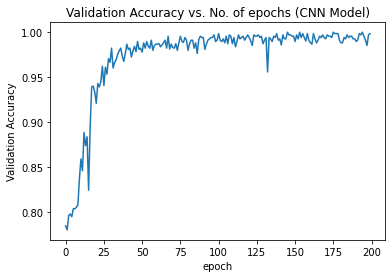

In [ ]:
plot_accuracies(history_cnn, 'val_acc', 'Validation Accuracy', 'Validation Accuracy vs. No. of epochs (CNN Model)')

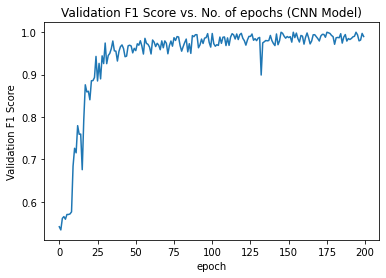

In [ ]:
plot_accuracies(history_cnn, 'val_f1', 'Validation F1 Score', 'Validation F1 Score vs. No. of epochs (CNN Model)')

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-b')
    plt.plot(val_losses, '-r')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs (CNN Model)');

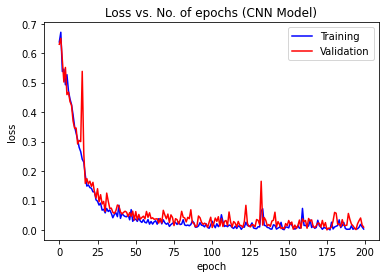

In [ ]:
plot_losses(history_cnn)

In [ ]:
test_history_cnn = [evaluate(model, validation_dataloader)]

In [ ]:
test_history_cnn

[{'val_acc': 0.9970588684082031,
  'val_f1': 0.979049026966095,
  'val_loss': 0.005086842924356461,
  'val_precision': 0.9778186678886414,
  'val_recall': 0.9803922176361084}]